## Support Vector Machines

Dataset is used here is from UCI machine learning repository.
Aim is to predict probability of default payments on credit card

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colours
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


importing data from a file

In [3]:
df = pd.read_excel('data/default_of_credit_card_clients.xls', header=1)

In [4]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [6]:
df.rename({'default payment next month' : 'DEFAULT'}, axis='columns', inplace=True)

In [7]:
df.drop('ID', axis=1, inplace=True)

Missing data: identifying and dealing with missing data

In [8]:
df.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
DEFAULT      int64
dtype: object

In [10]:
df['SEX'].unique()

array([2, 1], dtype=int64)

In [11]:
df['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0], dtype=int64)

In [12]:
len(df.loc[(df['EDUCATION'] == 0) | (df['MARRIAGE'] == 0)])

68

In [13]:
len(df)

30000

In [14]:
df_no_missing = df.loc[(df['EDUCATION'] != 0) & (df['MARRIAGE'] != 0)]

In [15]:
len(df_no_missing)

29932

Downsampling data

In [18]:
df_no_default = df_no_missing[df_no_missing['DEFAULT'] ==0]
df_default = df_no_missing[df_no_missing['DEFAULT'] ==1]

In [19]:
df_no_default_downsampled = resample(df_no_default, replace=False, n_samples=1000, random_state=42)
len(df_no_default_downsampled)
df_default_downsampled = resample(df_default, replace=False, n_samples=1000, random_state=42)
len(df_default_downsampled)

1000

In [20]:
df_downsample = pd.concat([df_no_default_downsampled, df_default_downsampled])
len(df_downsample)

2000

Formatting the data for SVM: splitting data into dependent and independent variables, One-hot-encoding, centering and scaling data

In [21]:
X = df_downsample.drop('DEFAULT', axis=1).copy()
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
641,130000,2,3,1,28,0,0,0,0,-2,...,50000,0,0,0,2500,1000,0,0,0,0
4678,170000,1,3,1,29,0,0,0,0,0,...,172307,35234,32869,33862,7200,7500,1200,1200,1500,1300
16004,180000,2,2,1,29,0,0,0,0,0,...,26310,26662,26166,26176,1800,1800,1500,1056,950,1000
22974,210000,2,2,2,32,-2,-2,-2,-2,-2,...,410,0,0,0,979,412,0,0,0,0
17535,190000,2,3,1,45,0,0,0,0,0,...,80548,81778,83082,84811,3300,3331,3359,2663,2751,3000


In [22]:
y = df_downsample['DEFAULT'].copy()
y.head()

641      0
4678     0
16004    0
22974    0
17535    0
Name: DEFAULT, dtype: int64

In [23]:
pd.get_dummies(X, columns=['MARRIAGE']).head()

,LIMIT_BAL,SEX,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
641,130000,2,3,28,0,0,0,0,-2,-2,...,0,2500,1000,0,0,0,0,1,0,0
4678,170000,1,3,29,0,0,0,0,0,0,...,33862,7200,7500,1200,1200,1500,1300,1,0,0
16004,180000,2,2,29,0,0,0,0,0,0,...,26176,1800,1800,1500,1056,950,1000,1,0,0
22974,210000,2,2,32,-2,-2,-2,-2,-2,-2,...,0,979,412,0,0,0,0,0,1,0
17535,190000,2,3,45,0,0,0,0,0,0,...,84811,3300,3331,3359,2663,2751,3000,1,0,0


In [24]:
X_encoded = pd.get_dummies(X, columns=['SEX','EDUCATION','MARRIAGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6'])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

Building a preliminary SVM

In [26]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

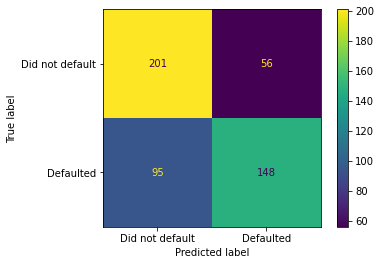

In [27]:
plot_confusion_matrix(clf_svm, X_test_scaled, y_test, values_format='d', display_labels=['Did not default','Defaulted'])

Optimizing Parameters with Cross Validation: using Cross Validation to find the best values for gamma and regularization

In [30]:
param_grid = [{'C': [0.5,1,10,100], 'gamma': ['scale',1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']},]
optional_params = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=0)
optional_params.fit(X_train_scaled, y_train)
print(optional_params.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


Building, Evaluating, Drawing and interpreting the final SVM

In [32]:
clf_svm = SVC(random_state=42, C=100, gamma=0.001)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=100, gamma=0.001, random_state=42)

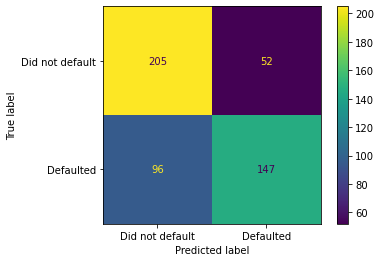

In [33]:
plot_confusion_matrix(clf_svm, X_test_scaled, y_test, values_format='d', display_labels=['Did not default','Defaulted'])

In [34]:
len(df_downsample.columns)

24

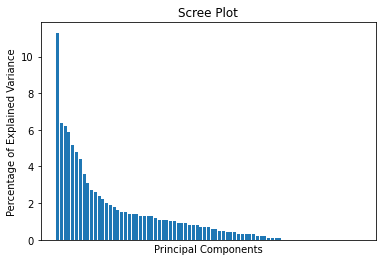

In [37]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]
plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [38]:
train_pc1_coords = X_train_pca[:,0]
train_pc2_coords = X_train_pca[:,1]
pca_train_scaled = scale(np.column_stack((train_pc1_coords, train_pc2_coords)))
param_grid=[{'C': [1,10,100,1000], 'gamma': ['scale',1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']},]
optional_params = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=0)
optional_params.fit(X_train_scaled, y_train)
print(optional_params.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [41]:
clf_svm = SVC(random_state=42, C=1000, gamma=0.001)
clf_svm.fit(pca_train_scaled, y_train)
X_test_pca=pca.transform(X_test_scaled)
test_pc1_coords = X_test_pca[:,0]
test_pc2_coords = X_test_pca[:,1]
x_min = test_pc1_coords.min() - 1
x_max = test_pc1_coords.max() + 1
y_min = test_pc2_coords.min() - 1
y_max = test_pc2_coords.min() + 1
xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1), np.arange(start=y_min, stop=y_max, step=0.1))
z = clf_svm.predict(np.column_stack((xx.ravel(),yy,ravel())))
z = z.reshape(xx.shape)
fig, ax = plt.subplots(figsize=(10,10))
ax.contourf(xx, yy, z, alpha=0.1)
cmap = colours.ListedColormap(['#e41a1c', '#4daf4a'])
scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c=y_train,cmap=cmap, s=100, edgecolors='k', alpha=0.7)
legend = ax.legend(scatter.legend_elements()[0],scatter.legend_elements()[1], loc="upper right")
legend.get_texts()[0].set_text("No Defalut")
legend.get_texts()[1].set_text("Yes Defalut")
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_tittle('Decsion surface using the PCA transformed/projected features')
plt.show()

NameError: name 'ravel' is not defined